# Simulation Models
This notebook explains how a simulation may be set up combining several types of classes into a "Model".
We first sketch the high-level concepts and structure, before demonstrating basic usage, i.e., adjusting existing models to specific applications. 
Then, we turn to more advanced usage such as development of new models and more fundamental adjustment of existing ones.
The code and documentation of the `pp.models` module are a useful supplement to this tutorial.

## Structure and concepts
The essential parts needed to set up a simulation are the following class types:

* Geometry
* Equations
* Variables
* Constitutive laws
* Boundary conditions
* Solution strategy

The first provides the mixed-dimensional domain, the next four define the problem, whereas the last one specifies how to solve it.
Additionally, values for constant material parameters are provided as `MaterialConstants` classes and visualization is handled by a `DataSavingMixin`.

PorePy provides combinations of the above components in classes such as `SinglePhaseFlow` and `Poromechanics`. 
Since the classes are composed with relatively advanced use of Python inheritance and mixin, the (intermediate to) advanced user is highly encouraged to familiarize her/himself with those concepts.
Specifically, all class types except solution strategies are treated as Mixins.
While providing a lot of flexibility, modularity and potential for reuse across applications, the result may come across as (overwhelmingly) complex.
TODO: Postpone previous sentences to later section?

The  combined classes are compatible with the method `run_time_dependent_problem` as are. 
However, most users will need to adjust at least some part of the class. 
Before offering examples on minimal adjustment, we give a brief introduction to each of the components.

### Geometry
TODO: Throughout: Links to documentation of classes.
The mixed-dimensional geometry is represented in a `MixedDimensionalGrid` created and stored in a `ModelGeometry` class. 
The class contains methods for specification of fracture network geometry and meshing.
It also provides helper methods for geometric operations, e.g. mixed-dimensional extensions of geometry information such as a single-dimensional grid's face normals.

### Equations
Define balance/conservation equations as `pp.ad.Operator`s compatible with the [automatic differentiation](https://github.com/pmgbergen/porepy/blob/develop/tutorials/automatic_differentiation.ipynb) framework.
The equations are passed to a `pp.EquationSystem` orchestrating discretization and assembly as requested by the solution strategy.

### Variables
Defines primary variables and related quantities such as reference values.
Primary variables are passed to the `pp.EquationSystem`, whereas secondary variables are implicitly defined as constitutive laws.

### Constitutive laws
This class defines derived quantities in terms of primary variables, material constants, (spatial) discretizations and other derived quantities.
Some prominent examples are fluxes (Darcy, Fourier, advection), porosity, aperture and internal energy.

PorePy provides laws for a quite extensive selection of quantities and even multiple relations (density may be constant or depend on pressure and/or temperature).
The modular laws are available in a library and combined as appropriate for specific models.

Each constitutive law function has its domain (list of subdomains or interfaces) as its sole parameter and returns an `pp.ad.Operator`.

### Boundary conditions
Here, boundary condition values and types are defined.
These typically correspond to flux type terms and their discretizations.

### Solution strategy
Specifies how to solve the problem through a contract with `run_time_dependent_problem`.
The base class `pp.SolutionStrategy` provides common functionality.
The child classes corresponding to individual equations/problems provide specific discretization parameters, TODO: Finish description.

### Material constants
Material constants are stored in and accessed through `SolidConstants` and `FluidConstants` objects.
These are _not_ mixins of the combined model. 
Rather, they are specified on instantiation and assigned as the attributes `solid` and `fluid`.
These classes are an important interface for relatively minor adjustments of models, as shown in the subsequent sections.

## Application examples
We shall start our examples using a single-phase flow model. 
As promised above, it is runable without any adjustments:

In [6]:
# Ignore this cell. It's a workaround, models not working without fractures.
import porepy as pp
import numpy as np
class GeometrySingleFracture2d(pp.ModelGeometry):
    def set_fracture_network(self) -> None:

        num_fracs = self.params.get("num_fracs", 1)
        domain = {"xmin": 0, "xmax": 2, "ymin": 0, "ymax": 1}
        if num_fracs == 0:
            p = np.zeros((2, 0), dtype=float)
            e = np.zeros((2, 0), dtype=int)
        elif num_fracs == 1:
            p = np.array([[0, 2], [0.5, 0.5]])
            e = np.array([[0], [1]])
        elif num_fracs == 2:
            p = np.array([[0, 2, 0.5, 0.5], [1, 1, 0, 1]])
            e = np.array([[0, 2], [1, 3]])
        else:
            raise ValueError("Only 0, 1 or 2 fractures supported.")
        self.fracture_network = pp.FractureNetwork2d(p, e, domain)

    def mesh_arguments(self) -> dict:
        return {"mesh_size_frac": 0.5, "mesh_size_bound": 0.5}


class MassBalance(
    GeometrySingleFracture2d,
    pp.fluid_mass_balance.SinglePhaseFlow,
):
    ...

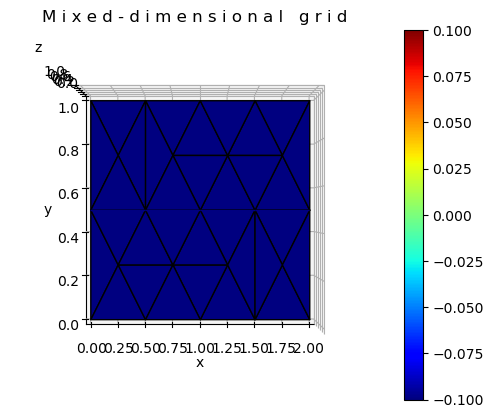

In [7]:

params = {}
single_phase = pp.fluid_mass_balance.SinglePhaseFlow(params)
single_phase = MassBalance(params)  
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure")

The empty `params` implies that unitary/zero default values are used for all constants.
Similarly, the default source term and boundary conditions are zero, resulting in absence of driving forces.
Let's change that!

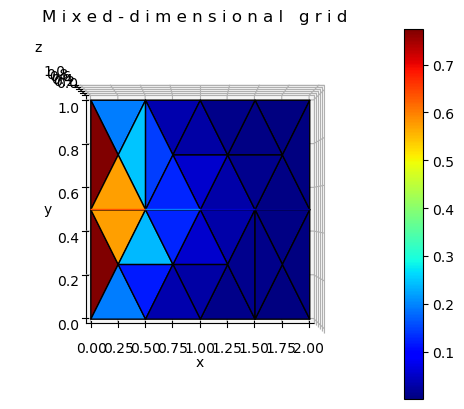

In [9]:
# Utility function to set wrap an array or matrix as an ad object
from porepy.models.constitutive_laws import ad_wrapper
class ModifiedFluidFlowBCs:
    def bc_values_darcy_flux(self, subdomains: list[pp.Grid]) -> pp.ad.Array:
        """
        
        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, _, west, *_ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            val_loc[west] = 1
            values.append(val_loc)
        return ad_wrapper(np.hstack(values), True, name="bc_values_darcy")

    def bc_values_mobrho(self, subdomains: list[pp.Grid]) -> pp.ad.Array:
        """
        Not sure where this one should reside.
        Note that we could remove the grid_operator BC and DirBC, probably also
        ParameterArray/Matrix (unless needed to get rid of pp.ad.Discretization. I don't see
        how it would be, though).
        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, _, west, *_ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            val_loc[west] = self.fluid.density() / self.fluid.viscosity()
            values.append(val_loc)
        return ad_wrapper(np.hstack(values), True, name="bc_values_mobrho")

class ModifiedSinglePhaseFlow(
    GeometrySingleFracture2d,
    ModifiedFluidFlowBCs,
    pp.fluid_mass_balance.SinglePhaseFlow,
):
    ...

fluid = pp.FluidConstants({"compressibility": 10, "viscosity": 0.1})
params = {"fluid": fluid}
single_phase = ModifiedSinglePhaseFlow(params)
pp.run_time_dependent_model(single_phase, params)
pp.plot_grid(single_phase.mdg, "pressure")

The ordering of the mixins in the inheritance paramount.
Python's method resolution order dictates that the first class/mixin takes precedence over later ones.
Thus, it is _crucial_ to place your modifications before the generic model!
You might try all permutations of geometry, BCs and base model and make sure you understand the implications.

## Primary equations
### Scaling
## Secondary equation combinations
class C(CouplingEffects, A, B)